<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Decide which algorithm and version of the data we are going to use for model training

Additionally, choose:
* if we'll skip scaling the data
* if we'll use full categories instead of dummies
* what fraction of the data we'll use for testing (0.1)
* if the data split will be randomised (it won't!)

In [1]:
FILENAME = 'all_models_except_neural_networks_with_pca'

ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'XG Boost (tree)'
#ALGORITHM = 'CatBoost'
#ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
#ALGORITHM_DETAIL = 'rerun best'
#ALGORITHM_DETAIL = 'custom'
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no dummies','autoencoding'] if 'catboost' in ALGORITHM.lower() else ['autoencoding']
DATA_DETAIL = ['pca']
VERSION = '10'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

use_dimension_reduction = True # True
pca_data_retain = 0.95 #0.5 #0.99 # 0.9999999999999 # 0.95
pca_data_retain = 0.9999999999999

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA VERSION: {VERSION}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'use_dimension_reduction: {use_dimension_reduction}')
print(f'pca_data_retain: {pca_data_retain}')


model_uses_feature_importances = 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower()
create_python_script = True

ALGORITHM: Linear Regression (Ridge)
ALGORITHM_DETAIL: random search
DATA VERSION: 10
DATA_DETAIL: ['pca']
use_dimension_reduction: True
pca_data_retain: 0.9999999999999


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: loading all dependencies



In [2]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import os

start_timestamp = datetime.now()

module_path = os.path.abspath(os.path.join('..', '..', '..'))
if module_path not in sys.path:
    #sys.path.append(module_path+"\\zfunctions")
    sys.path.append(module_path)

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

if "JPY_PARENT_PID" in os.environ:
    is_jupyter = True
else:
    is_jupyter = False

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
OVERRIDE_VERBOSE = 1
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
#not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies
using_catboost = 'catboost' in ALGORITHM.lower()

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory

    set_csv_directory('final_split')
else:
    cloud_run = True

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset, get_source_dataframe
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

print(env_vars)
start = datetime.now()

{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [3]:
if is_jupyter:
    %pip install tabulate

    if ALGORITHM == 'CatBoost':
        %pip install catboost

    if ALGORITHM == 'Light Gradient Boosting':
        %pip install lightgbm

    !pip install pydot
    !pip install graphviz

Note: you may need to restart the kernel to use updated packages.


#### Include any overrides specific to the algorthm / python environment being used

In [4]:
running_locally = run_env == 'local'

if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 50
    if use_gpu:
        OVERRIDE_JOBS = 4

if running_locally:
    if ALGORITHM.lower() in ['random forest', 'xg boost', 'xg boost (linear)', 'xg boost (tree)']:
        OVERRIDE_N_ITER = 3
    elif 'linear regression' in ALGORITHM.lower():
        OVERRIDE_N_ITER = 15
    else:
        OVERRIDE_N_ITER = 5

if ALGORITHM.lower() in ['xg boost', 'xg boost (linear)', 'xg boost (tree)']:
    OVERRIDE_N_ITER = 20

if 'forest' in ALGORITHM.lower() or True:
    OVERRIDE_VERBOSE = 2


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: defining the model pipeline



In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', Ridge())])

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: get the data

In [6]:
columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)
LABEL = 'Price'

In [7]:
df, retrieval_type = get_source_dataframe(cloud_run, VERSION, folder_prefix='../../../', row_limit=None)
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v10.csv


In [8]:
print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [9]:
df = preprocess(df, version=VERSION)
df = df.dropna()

In [10]:
df.head(5)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__1 bedroom,...,feature__reception room,feature__separate kitchen,feature__share of freehold,feature__three bedrooms,feature__three double bedrooms,feature__top floor,feature__two bathrooms,feature__two bedrooms,feature__two double bedrooms,feature__two reception rooms
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,...,0,1,0,0,0,0,0,0,0,0
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,0,...,0,0,0,0,0,1,0,0,1,0
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,...,0,0,0,0,0,0,0,0,0,0
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,0,...,0,0,0,0,0,0,0,0,0,0
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD,0,...,0,0,0,0,0,0,0,0,0,0


<code
style = "background:red;color:red" > ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** </code>

## NEW Stage: do autoencoding


In [11]:

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Tensorflow / Keras
from tensorflow import keras  # for building Neural Networks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model

print('Keras: %s' % keras.__version__)  # print version
from keras.models import Model, load_model  # for creating a Neural Network Autoencoder model
from keras import Input  # for instantiating a keras tensor
from keras.layers import Dense, LeakyReLU, BatchNormalization  # for adding layers to AE model
from keras.utils import plot_model  # for plotting model diagram

print("Tensorflow version:", tf.__version__)


Keras: 2.9.0
Tensorflow version: 2.9.1


In [12]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

if 'forest' in ALGORITHM.lower() or ALGORITHM.lower() == 'light gradient boosting':
    #y_train_orig = y_train
    y_train_orig = y_train_orig.ravel()

#print(X_train[0])
print(df.shape)
print(X_train_orig.shape, X_test_orig.shape, y_train_orig.shape, y_test_orig.shape, X_train_index.shape,
      X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



(44127, 59)
(39714, 61) (4413, 61) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [13]:

if not use_dimension_reduction:
    print(DATA_DETAIL)
    DATA_DETAIL = [] # DATA_DETAIL.remove('pca')
    print(DATA_DETAIL)
else:
    print(DATA_DETAIL)
    DATA_DETAIL = ['pca'] # DATA_DETAIL.append('pca')
    DATA_DETAIL.append(str(round(pca_data_retain,4))+"% retain")
    print(DATA_DETAIL)

if use_dimension_reduction:

    from sklearn.decomposition import PCA

    pca = PCA()
    pca.fit(X_train_orig)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= pca_data_retain) + 1
    print("preserve this many features:", d, "out of", X_train_orig.shape[1])

    pca = PCA(n_components=pca_data_retain)
    X_train = pca.fit_transform(X_train_orig)
    X_test =  pca.transform(X_test_orig)
    y_train = y_train_orig
    y_test = y_test_orig
else:
    X_train, X_test, y_train, y_test = X_train_orig, X_test_orig, y_train_orig, y_test_orig

['pca']
['pca', '1.0% retain']
preserve this many features: 60 out of 61


In [14]:
print(X_train_orig.shape)
X_train_orig[0:5]

(39714, 61)


array([[ 3.00000000e+00,  3.00000000e+00,  3.16613257e-01,
         5.14597600e+01,  1.29390000e-01,  3.99600000e-02,
         2.33810000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+0

In [15]:
print(X_train.shape)
X_train[0:5]

(39714, 60)


array([[ 1.65581106e+00,  3.89158039e-01,  7.80638747e-01,
         1.20756246e+00,  1.48619776e-01, -4.77429510e-01,
        -1.04218267e-01, -1.96422785e-01,  3.31725221e-01,
         6.03496469e-01, -4.31130937e-01, -1.43243341e-01,
        -2.46351374e-02, -1.18207463e-01, -1.07942376e-01,
        -2.11605247e-02,  2.11512245e-04, -6.79546729e-02,
        -5.73836425e-02, -9.34268102e-02, -5.63922268e-02,
         6.61489194e-02, -2.89809856e-01,  1.97525418e-02,
         1.60811306e-01, -2.57014908e-03, -3.46816242e-01,
         7.00490899e-02,  1.18990945e-01, -6.83287045e-02,
        -4.53992705e-03, -1.46664353e-02, -6.87591153e-03,
        -5.18423636e-02,  1.59091287e-02,  2.10702560e-02,
        -3.89315741e-02, -8.70374410e-02, -5.57078734e-02,
         3.40583560e-03,  2.03069017e-02, -1.92136820e-02,
         1.05707356e-02,  5.86406207e-03,  1.43430073e-02,
        -5.55592913e-03, -2.29356426e-02, -2.22353321e-02,
         1.89244912e-02, -2.14742783e-02,  4.26367994e-0

In [16]:
y_train[0:5]

array([[525000.],
       [225000.],
       [475000.],
       [475000.],
       [425000.]])

In [17]:
X_test[0:5]

array([[-1.05706399e+00, -3.80189985e-02, -2.65634411e-01,
         2.39452089e-01, -7.90697576e-02,  2.15616771e-01,
         1.07458582e-01, -1.29176806e-01, -8.58523086e-02,
        -1.78422542e-02, -3.09733698e-02, -1.02390906e-01,
        -1.15134217e-01, -4.89389524e-02, -3.74611810e-02,
        -7.60605332e-03, -1.34746901e-02, -5.39640824e-02,
        -2.71390702e-02, -4.63884851e-02,  3.27209431e-02,
         4.59968669e-03, -4.63984810e-02, -2.44721738e-02,
        -2.26670370e-02, -5.55096470e-02,  2.46382312e-02,
        -2.46424978e-02,  2.47967796e-02,  5.85671921e-03,
        -7.79190112e-03, -5.21205922e-03, -1.84733733e-02,
         1.41346216e-02, -2.31095926e-03, -2.40462353e-02,
         4.93551479e-04,  1.09650431e-02,  2.00748881e-03,
         4.76322931e-04, -6.12590868e-05, -2.09448622e-03,
         1.50408615e-02, -5.03541929e-03, -8.97665577e-03,
        -2.12523938e-02,  2.22138154e-03, -1.84191645e-02,
         1.93931040e-02, -1.68176370e-02,  8.53753394e-0

End of autoencoding segment

<code
style = "background:black;color:black" > ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** </code>

In [18]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [19]:
starter_model = starter_pipe[-1]

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage:
* #### retrieve the hyperparameters for this model, and
* #### train the model



In [20]:
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key2, value in param_options.items():
            #print(key2, value, vary)
            if key2 != vary and key2 != 'model__' + vary:
                try:
                    param_options[key2] = [param_options[key2][0]]
                except:
                    # value probably wasn't an list of options
                    param_options[key2] = [param_options[key2]]
        return param_options


    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "n_estimators"
    options_block = automl_step(options_block, explore_param)

    ALGORITHM_DETAIL = 'grid search (implied)'

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS,
                                                                  override_verbose=OVERRIDE_VERBOSE
                                                                  )

if not using_catboost and len(param_options.keys()) > 2 and not already_timed and debug_mode:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)
#print('\n\nHyperparameters:')
#param_options if not using_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 2


In [21]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not using_catboost:
    if ALGORITHM_DETAIL == 'grid search' or ALGORITHM_DETAIL == 'grid search (implied)':
        print('grid search (or implied)')
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            #error_score='raise'
        )
    elif ALGORITHM_DETAIL == 'custom':
        user_defined_params = {'model__booster': 'dart', 
                               'model__colsample_bytree': 0.9, 
                               'model__lambda': 1, 
                               'model__learning_rate': 0.1, 
                               'model__max_depth': [15,20,25], #[15,20,30], 
                               'model__max_features': None, 
                               'model__max_leaf_nodes': 20, 
                               'model__max_samples': 1, 
                               'model__min_sample_split': None, 
                               'model__min_samples_leaf': 2000,
                               'model__n_estimators': [20,50,100], #[50,100,150], 
                               'model__n_jobs': 3, 
                               'model__objective': 
                               'reg:squarederror', 
                               'model__subsample': 0.5, 
                               'model__tree_method': 'hist', 
                               'model__verbosity': 2, 
                               #'score': 0.727131957076238, 'time': 134.17490124702454, 'date run': '2022-12-07 09:43:37.103009', 'method': 'random search'
                              }

        for each in user_defined_params:
            if type(user_defined_params[each]) != list:
                user_defined_params[each] = [user_defined_params[each]]
                
        print('user_defined_params:',user_defined_params)
        
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            #param_grid=params_for_best_results,
            param_grid=user_defined_params,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )

    elif ALGORITHM_DETAIL == 'rerun best':
        results_for_best_results = get_results()
        model_for_best_results = results_for_best_results[key]
        
        params_for_best_results = model_for_best_results['best params']
        method_for_best_results = model_for_best_results['best method']

        print(method_for_best_results)
        print(DATA_DETAIL)
        
        if 'pca' in method_for_best_results and 'pca' not in DATA_DETAIL:
            raise ValueError("can't rerun this here, pca encoding was used")
            
        for each in params_for_best_results:
            if type(params_for_best_results[each]) != list:
                params_for_best_results[each] = [params_for_best_results[each]]
        
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            #param_grid=params_for_best_results,
            param_grid=params_for_best_results,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )

    else:
        print('random search')
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
        )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:
    from catboost import CatBoostRegressor, Pool

    if no_dummies:
        pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
        pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    else:
        pool_Xtrain = Pool(X_train, cat_features=[], label=y_train)
        pool_Xtest = Pool(X_test, cat_features=[], label=y_test)
    import sys

    starter_model = model = CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE',
                                              objective='RMSE')

    output = starter_model.randomized_search(options_block,  # param_options,
                                             X=pool_Xtrain,  # X_train,
                                             #y=y_train,
                                             #cat_features=[],
                                             cv=5,
                                             n_iter=100,
                                             partition_random_seed=101,
                                             calc_cv_statistics=True,
                                             #search_by_train_test_split=True,
                                             refit=True,
                                             shuffle=True,
                                             stratified=None,
                                             #train_size=0.8,
                                             #train_size=1,
                                             verbose=True,
                                             plot=True,
                                             log_cout=sys.stdout,
                                             log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


random search
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__alpha=1e-05, model__copy_X=True, model__fit_intercept=True, model__max_iter=100000, model__positive=False, model__random_state=101, model__solver=cholesky, model__tol=0.01; total time=   0.1s
[CV] END model__alpha=0.001, model__copy_X=False, model__fit_intercept=False, model__max_iter=1000000, model__positive=False, model__random_state=101, model__solver=sag, model__tol=1e-05; total time=   1.9s
[CV] END model__alpha=0.1, model__copy_X=False, model__fit_intercept=True, model__max_iter=10000, model__positive=False, model__random_state=101, model__solver=lsqr, model__tol=0.01; total time=   0.1s
[CV] END model__alpha=0.01, model__copy_X=True, model__fit_intercept=False, model__max_iter=100, model__positive=False, model__random_state=101, model__solver=cholesky, model__tol=0.0001; total time=   0.1s
[CV] END model__alpha=0.01, model__copy_X=False, model__fit_intercept=False, model__max_iter=100, m

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
42 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py", line 1130, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/usr/l

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__alpha=0.01, model__copy_X=False, model__fit_intercept=False, model__max_iter=1000000, model__positive=False, model__random_state=101, model__solver=cholesky, model__tol=0.001; total time=   0.1s
[CV] END model__alpha=0.01, model__copy_X=False, model__fit_intercept=False, model__max_iter=1000000, model__positive=False, model__random_state=101, model__solver=cholesky, model__tol=0.001; total time=   0.1s
[CV] END model__alpha=100, model__copy_X=True, model__fit_intercept=True, model__max_iter=100000, model__positive=False, model__random_state=101, model__solver=lbfgs, model__tol=0.01; total time=   0.1s
[CV] END model__alpha=100, model__copy_X=True, model__fit_intercept=True, model__max_iter=100000, model__positive=False, model__random_state=101, model__solver=lbfgs, model__tol=0.01; total time=   0.1s
[CV] END model__alpha=100, model__copy_X=True, model__fit_intercept=True, model__max_iter=100000, model__posi

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py", line 1130, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/usr/l

Total fit/CV time      : 46 seconds   (1672747874.0902967 ==> 1672747920.458107)

average fit/score time = 0.2s/0.01s
max fit/score time     = 1.33s/0.02s
refit time             = 0.34s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model', Ridge())]),
                   n_iter=100, n_jobs=3,
                   param_distributions={'model__alpha': [1e-05, 0.0001, 0.001,
                                                         0.01, 0.1, 1, 10, 100,
                                                         1000],
                                        'model__copy_X': [True, False],
                                        'model__fit_intercept': [True, False],
                                        'model__max_iter': [10000, 1000, 100,
                                                            100000, 1000000],
                                        'model__positive': [False],
                                        'model__random_state': [101],
                                        'model__solver': ['auto', 'svd',
                                                          'cholesky', 'lsqr',
                                                          'sparse_cg', 'sag',
                                                          'saga', 'lbfgs'],
                                        'model__tol': [1e-05, 0.0001, 0.001,
                                                       0.01]},
                   return_train_score=True, scoring='r2', verbose=2)

In [22]:
if ALGORITHM_DETAIL == 'grid search' or ALGORITHM_DETAIL == 'grid search (implied)':
    print(crossval_runner.best_params_)

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Get the results and print some graphs



In [23]:
if not using_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')

    print("Best Params\n", crossval_runner.best_params_, "\n---------------------")

    if debug_mode:
        print("CV results\n", crossval_runner.cv_results_, "\n---------------------")
        #print("Best Params\n",crossval_runner["best_params_"], "\n---------------------")

else:
    print(cat_params)
    print(cat_cv_results)

Best Params
 {'model__tol': 0.01, 'model__solver': 'sag', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 1} 
---------------------


In [24]:
key = f'{ALGORITHM} (v{VERSION})'.lower()

if not using_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)

if not using_catboost:
    if is_jupyter: display(cv_results_df_sorted)

    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c and c != 'params'])

    cv_results_df_summary = cv_results_df[debug_cols].head(7)
    cv_results_df_summary.set_index('rank_test_score', inplace=True)

    if is_jupyter: display(cv_results_df_summary)

53 fits were total failures


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.01/sag/101/False/100000/True/True/1,1,0.468565,0.273064,0.009097,"{'model__tol': 0.01, 'model__solver': 'sag', '..."
1,0.01/sag/101/False/1000000/True/True/0.1,2,0.468565,0.272250,0.007024,"{'model__tol': 0.01, 'model__solver': 'sag', '..."
2,0.01/sag/101/False/100000/True/True/0.1,2,0.468565,0.303257,0.010288,"{'model__tol': 0.01, 'model__solver': 'sag', '..."
3,0.01/sag/101/False/1000/True/True/0.001,4,0.468565,0.282706,0.009059,"{'model__tol': 0.01, 'model__solver': 'sag', '..."
4,0.001/saga/101/False/10000/True/True/100,5,0.468506,0.300949,0.008544,"{'model__tol': 0.001, 'model__solver': 'saga',..."
5,0.0001/svd/101/False/100/True/False/100,6,0.468506,0.206639,0.008035,"{'model__tol': 0.0001, 'model__solver': 'svd',..."
6,0.001/auto/101/False/1000/True/True/100,6,0.468506,0.058739,0.006843,"{'model__tol': 0.001, 'model__solver': 'auto',..."
7,1e-05/auto/101/False/100/True/False/100,6,0.468506,0.064514,0.007296,"{'model__tol': 1e-05, 'model__solver': 'auto',..."
8,0.001/svd/101/False/1000000/True/True/100,6,0.468506,0.171187,0.009418,"{'model__tol': 0.001, 'model__solver': 'svd', ..."
9,0.001/auto/101/False/1000000/True/True/10,10,0.468503,0.064201,0.008323,"{'model__tol': 0.001, 'model__solver': 'auto',..."


,mean_test_score,mean_fit_time,mean_score_time,param_model__tol,param_model__solver,param_model__random_state,param_model__positive,param_model__max_iter,param_model__fit_intercept,param_model__copy_X,param_model__alpha,params2
rank_test_score,,,,,,,,,,,,
1,0.468565,0.273064,0.009097,0.01,sag,101,False,100000,True,True,1,0.01/sag/101/False/100000/True/True/1
2,0.468565,0.272250,0.007024,0.01,sag,101,False,1000000,True,True,0.1,0.01/sag/101/False/1000000/True/True/0.1
2,0.468565,0.303257,0.010288,0.01,sag,101,False,100000,True,True,0.1,0.01/sag/101/False/100000/True/True/0.1
4,0.468565,0.282706,0.009059,0.01,sag,101,False,1000,True,True,0.001,0.01/sag/101/False/1000/True/True/0.001
5,0.468506,0.300949,0.008544,0.001,saga,101,False,10000,True,True,100,0.001/saga/101/False/10000/True/True/100
6,0.468506,0.206639,0.008035,0.0001,svd,101,False,100,True,False,100,0.0001/svd/101/False/100/True/False/100
6,0.468506,0.058739,0.006843,0.001,auto,101,False,1000,True,True,100,0.001/auto/101/False/1000/True/True/100


<code style="background:blue;color:blue">**************</code>

#### Mini Stage: Make predictions



In [25]:
if not using_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [26]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Linear Regression (Ridge)----------
R square Accuracy 0.47079450628683117
Mean Absolute Error Accuracy 62597.94158160654
Mean Squared Error Accuracy 5978119917.978841
Root Mean Squared Error 77318.30260668453


In [27]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)

combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,584977,424977.376185,265.610860,72.648515,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,369976,247976.219716,203.259196,67.024908,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,325457,217457.120114,201.349185,66.815905,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
83639617,190000,438907,248907.026095,131.003698,56.710650,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
122821142,170000,359170,189170.544387,111.276791,52.668724,170000,2,1,0.093936,51.430690,0.024020,0.069030,0.128440,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122572841,375000,374778,221.293074,0.059011,0.059046,375000,2,1,0.401475,51.455226,-0.358379,0.044494,0.253959,LEASEHOLD
124394330,500000,499707,292.468702,0.058494,0.058528,500000,2,1,0.531089,51.588973,-0.295429,0.089253,0.191009,FREEHOLD
121426745,500000,500278,278.581743,0.055716,0.055685,500000,3,1,0.852956,51.450091,-0.429875,0.049629,0.325455,FREEHOLD
113621618,385000,385059,59.373687,0.015422,0.015419,385000,2,1,0.346870,51.421533,-0.172366,0.078187,0.067946,LEASEHOLD


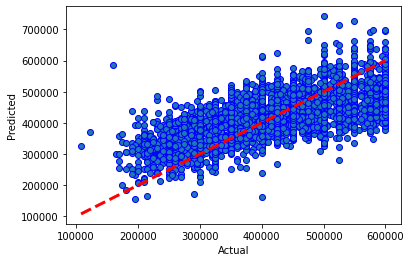

In [28]:
best_model_fig, best_model_ax = plt.subplots()
best_model_ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
best_model_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
best_model_ax.set_ylabel('Predicted')
best_model_ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')

plt.show()

In [29]:
if not using_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    if showable_increment == 0: showable_increment = 1
    for i in range(0, total_fits, showable_increment):
        if debug_mode: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key2, value in graph_pipe_params.items():
                graph_params[key2.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key2, value in graph_pipe_params.items():
        graph_params[key2.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
11 ==> 11
{'model__tol': 0.001, 'model__solver': 'cholesky', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 10}
22 ==> 22
{'model__tol': 1e-05, 'model__solver': 'cholesky', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 0.1}
33 ==> 33
{'model__tol': 0.001, 'model__solver': 'saga', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 1000000, 'model__fit_intercept': True, 'model__copy_X': False, 'model__alpha': 0.0001}
44 ==> 44
{'model__tol': 1e-05, 'model__solver': 'svd', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 1000000, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 1000}
-1 ==> -1
{'model__tol': 0.0001, 'model__solver': 'saga', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 1000, 

0
1
2
3
4
5


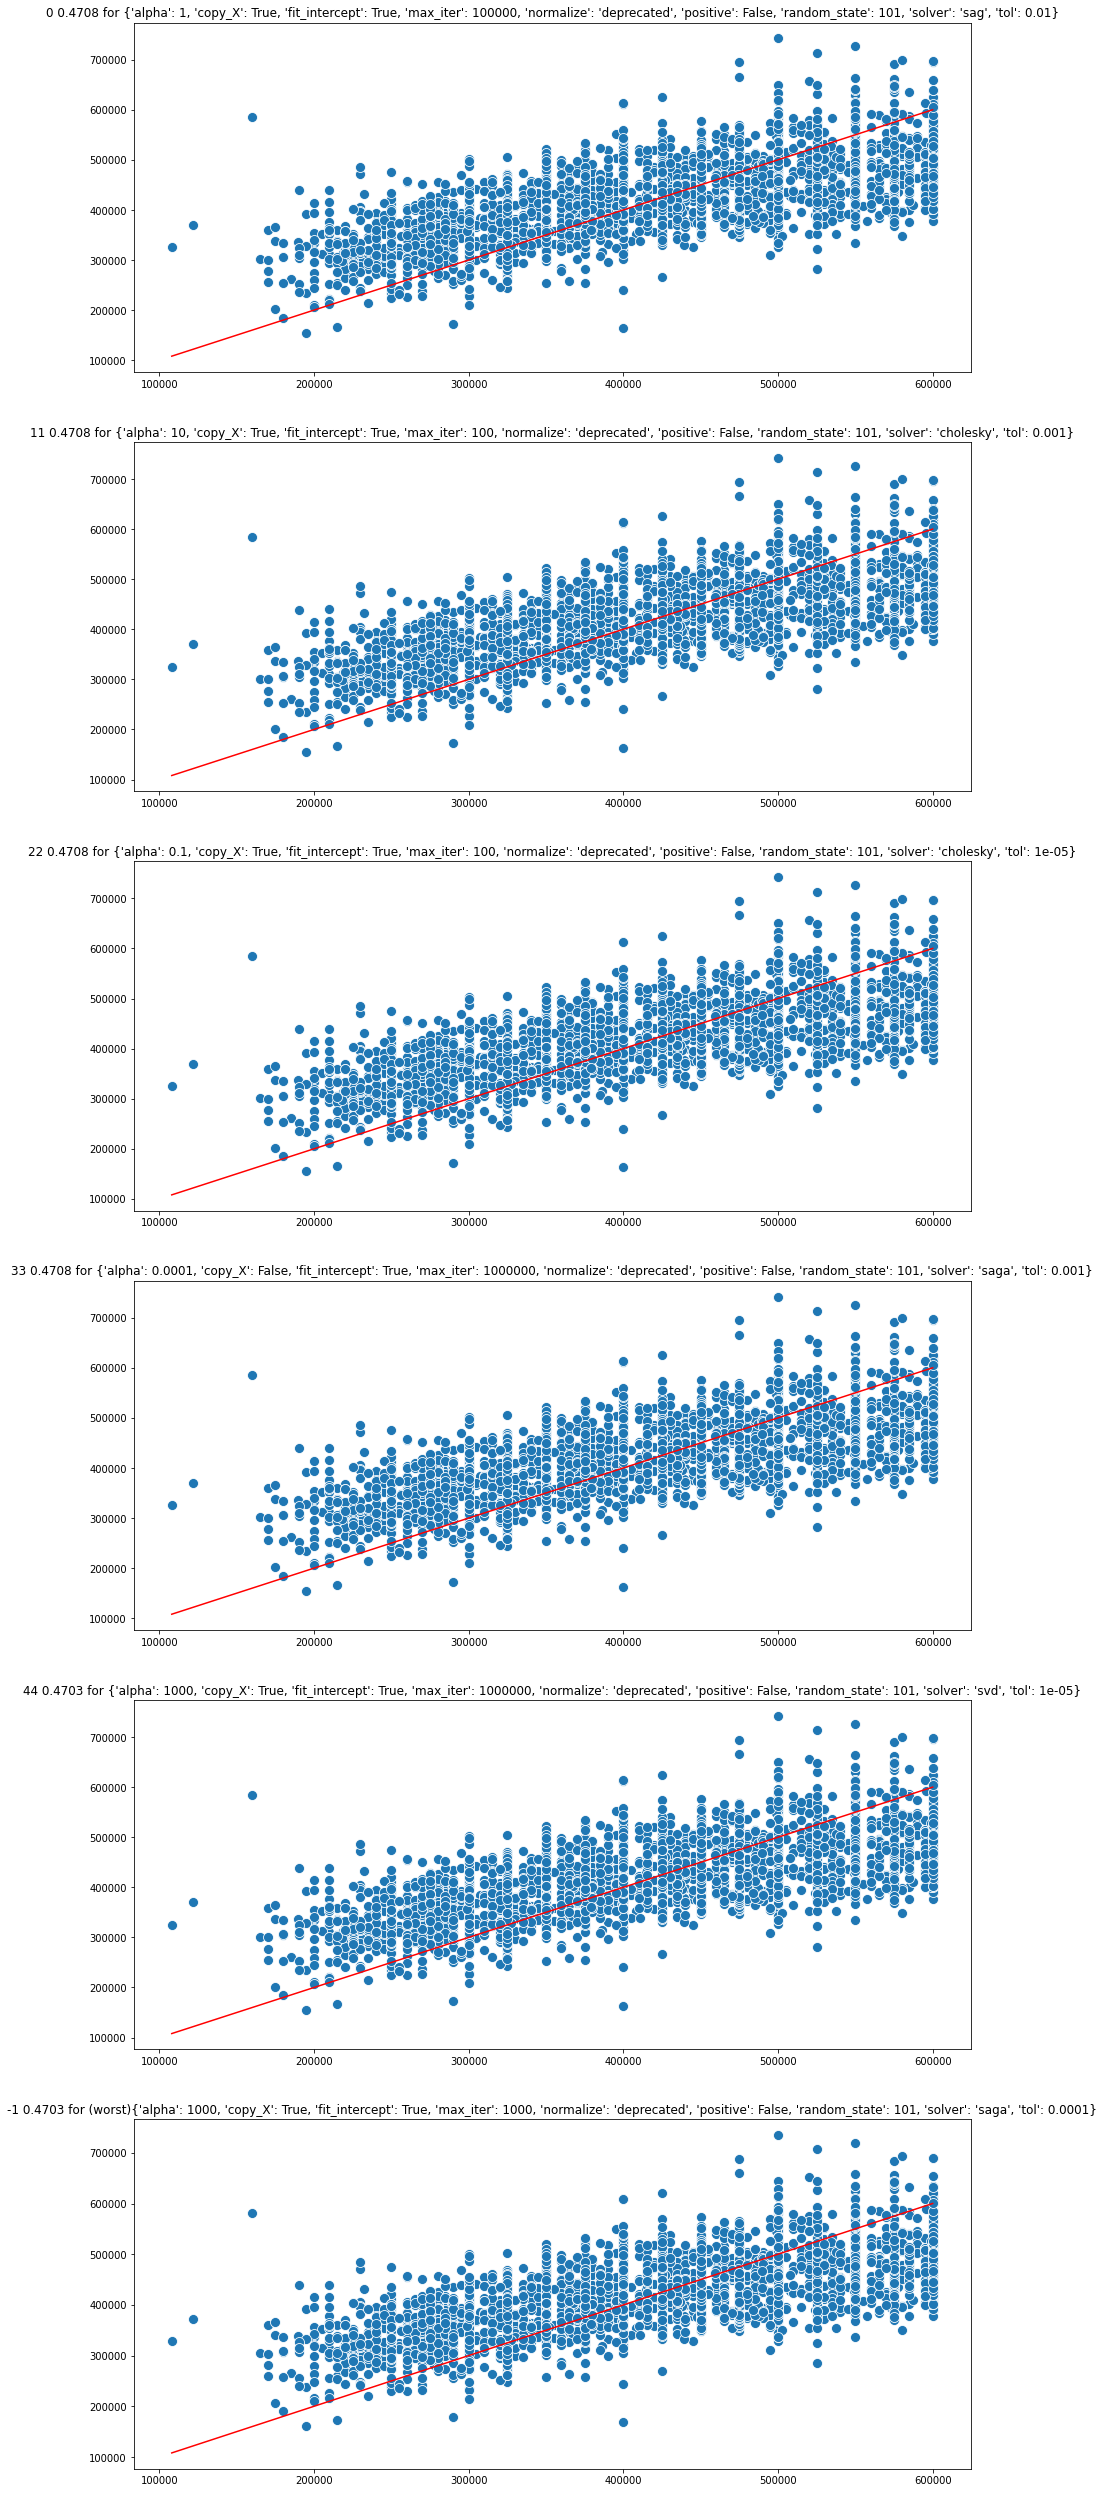

In [30]:
if not using_catboost:
    evolution_of_models_fig, evolution_of_models_axes = plt.subplots(nrows=len(best_model_scores.keys()),
                                                                     figsize=(15, 45))

    ax_index = -1
    #for i in best_model_scores.keys():
    for i, ax_index in zip(best_model_scores.keys(), range(0, len(best_model_scores.keys()))):
        #ax_index += 1
        #print(len(best_model_scores.keys()))
        #print('i',i, "ax_index",ax_index)
        if i >= 0:
            # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            # plt.scatter(y_test, best_model_predictions[i])
            # # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            # if len(best_models[i].keys()) < 30:
            #     plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            # else:
            #     plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            # plt.show()

            #>>>

            plt.subplots_adjust(hspace=0.2)
            plt.subplots_adjust(wspace=0.2)

            #.flatten()
            #coordinates = evolution_of_models_axes[i]

            if len(best_models[i].keys()) < 30:
                eom_title = str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i])
            else:
                eom_title = str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i)

            print(ax_index)
            sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
                         ax=evolution_of_models_axes[ax_index], color='red')
            sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(),
                            ax=evolution_of_models_axes[ax_index],
                            s=100).set(title=eom_title)

            #<<<

    #plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    #plt.scatter(y_test, best_model_predictions[-1])

    if len(best_models[i].keys()) < 30:
        eom_title = str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst)" + str(best_models[-1])
    else:
        eom_title = str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i)

    print(ax_index)
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=evolution_of_models_axes[ax_index],
                 color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=evolution_of_models_axes[ax_index],
                    s=100).set(title=eom_title)

    plt.show()

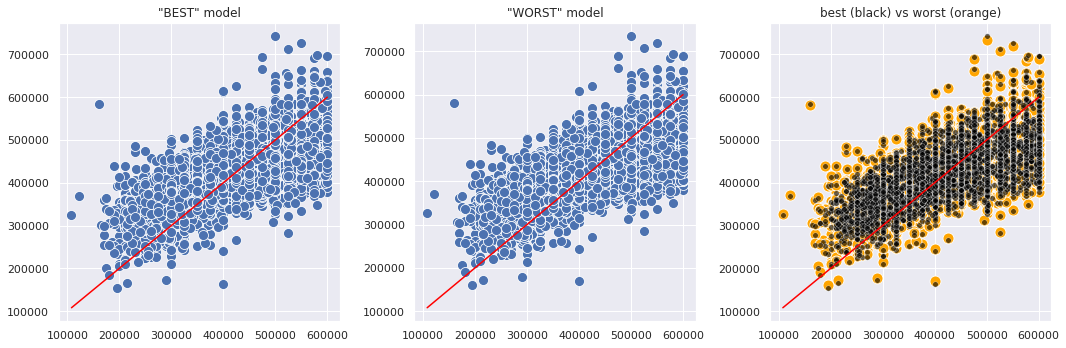

In [31]:
if not using_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    worst_and_best_model_fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    worst_and_best_model_fig.tight_layout()
    plt.show()

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Evaluate the model



In [32]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_best_model_fit_time if not using_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""

method = f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': R2,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not using_catboost else cat_params,
    '_method': method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)
new_results

linear regression (ridge) (v10)


{'_score': 0.47079450628683117,
 'R square Accuracy': 0.47079450628683117,
 'Mean Absolute Error Accuracy': 62597.94158160654,
 'Mean Squared Error Accuracy': 5978119917.978841,
 'Root Mean Squared Error': 77318.30260668453,
 '_train time': 0.3415985107421875,
 'random_state': 101,
 'date': '2023-01-03 12:12:04.130619',
 '_params': {'model__tol': 0.01,
  'model__solver': 'sag',
  'model__random_state': 101,
  'model__positive': False,
  'model__max_iter': 100000,
  'model__fit_intercept': True,
  'model__copy_X': True,
  'model__alpha': 1},
 '_method': 'random search(pca,1.0% retain)',
 'run_env': 'gradient',
 'first run': '2022-12-01 14:21:36.707990',
 'best is shared': False,
 'silver score': 0.4708062463391607,
 'silver time': 0.08964244524637859,
 'silver params': {'model__alpha': 0.0001,
  'model__copy_X': False,
  'model__fit_intercept': True,
  'model__max_iter': 10000,
  'model__positive': False,
  'model__random_state': 101,
  'model__solver': 'lsqr',
  'model__tol': 0.001},
 

In [33]:
crossval_runner.best_estimator_ if not using_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 Ridge(alpha=1, max_iter=100000, random_state=101, solver='sag',
                       tol=0.01))])

In [34]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not using_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        new_model_decision = f"pickled new version of model\n{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})"
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    new_model_decision = f"not updated saved model, the previous run was better\n{old_results_json[key]['_score']} is worse than or equal to {old_best_score}"

print(new_model_decision)

not updated saved model, the previous run was better
0.47079450628683117 is worse than or equal to 0.4708062463710102


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Investigate the feature importances (if applicable)


In [35]:
if model_uses_feature_importances:
    feature_importances = crossval_runner.best_estimator_[
        -1].feature_importances_ if not using_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    feature_importances_output = ""
    for f in range(X_train.shape[1]):
        #print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]), df_features.columns[indices[f] + 1])
        feature_importances_output += ('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]))
        feature_importances_output += '\t\t'
        feature_importances_output += (df_features.columns[indices[f] + 1])
        feature_importances_output += '\n'
    print(feature_importances_output)
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (Ridge) does not have feature_importances, skipping


In [36]:
if model_uses_feature_importances:
    indices = np.argsort(feature_importances)

    feature_importance_fig, best_model_ax = plt.subplots(figsize=(20, 20))
    best_model_ax.barh(range(len(feature_importances)), feature_importances[indices])
    best_model_ax.set_yticks(range(len(feature_importances)))
    _ = best_model_ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (Ridge) does not have feature_importances, skipping


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Write the final report for this algorithm and dataset version

In [37]:
from bs4 import BeautifulSoup


def include_in_html_report(type, section_header=None, section_figure=None, section_content=None,
                           section_content_list=None):
    # writePath_html = r'model_results/%s (html).html' % key
    # writePath_md = r'model_results/%s (md).md' % key
    results_root = '../../F_evaluate_model'
    writePath_html = f'{results_root}/html/{key}.html'.replace(" ", "_").replace("(", "_").replace(")", "_")
    writePath_md = f'{results_root}/markdown/{key}.md'

    #isinstance(ini_list2, list)
    if not section_content_list:
        section_content_list = [section_content]

    if type == 'header':
        w = 'w' if section_figure <= 1 else 'a'
        with open(writePath_html, w) as f1:
            headers = f'<h{section_figure}>{section_content}</h{section_figure}>'
            f1.write(headers)
        with open(writePath_md, w) as f2:
            headers = f'{"#" * int(section_figure)} {section_content}\n'
            f2.write(headers)
    else:
        if section_header:
            with open(writePath_html, 'a') as f1:
                f1.write(f'<h3>{section_header}</h3>')
            with open(writePath_md, 'a') as f2:
                f2.write(f'### {section_header}\n')

        if type == 'dataframe':
            with open(writePath_html, 'a') as f1:
                dfAsString = section_content.to_html()
                f1.write(dfAsString)
            with open(writePath_md, 'a') as f2:
                dfAsString = section_content.to_markdown()
                f2.write(dfAsString + '\n')
        elif type == 'graph':
            filename = key + "_" + section_content
            #section_figure.savefig(f'model_results/artifacts/{filename.replace(" ", "_")}')
            section_figure.savefig(
                f'{results_root}/artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")}')

            with open(writePath_html, 'a') as f1:
                dfAsString = f'<img src="../artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")}"/>'
                f1.write(dfAsString)

            with open(writePath_md, 'a') as f2:
                #dfAsString = f'(./model_results/artifacts/{filename}) \n'
                #dfAsString = f'![detail](./artifacts/{filename.replace(" ","_")})'
                dfAsString = f'![detail](../artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")})'
                f2.write(dfAsString)
                f2.write('\n')
        elif type == 'json':

            # html_content_parsed = [[cell.text for cell in row("td")]
            #              for row in BeautifulSoup(content,features="html.parser")("tr")]
            #
            # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}

            #xxxprint(json.dumps(html_content_dictionary, indent=4))

            with open(writePath_html, 'a') as f1:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                f1.write(str(soup.prettify()))
            with open(writePath_md, 'a') as f2:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                #f2.write(str(soup.prettify()))

                # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}
                # f2.write(json.dumps(html_content_dictionary, indent=4))

                import ast
                loads = ast.literal_eval(section_content)
                #df = pd.DataFrame.from_dict(loads)
                #df.drop(['dont'], axis=1, inplace=True)
                #print(df.to_markdown(index=False,tablefmt='fancy_grid'))
                for each in loads:
                    f2.write(each + " = " + str(loads[each]) + "\n\n")

        elif type == 'dict':

            for section_content in section_content_list:
                if isinstance(section_content, str):
                    import ast
                    section_content = ast.literal_eval(section_content)

                with open(writePath_html, 'a') as f1:
                    soup = BeautifulSoup(str(section_content), "html.parser")
                    f1.write(str(soup.prettify()))
                with open(writePath_md, 'a') as f2:
                    for each in section_content:
                        f2.write(each + " = " + str(section_content[each]) + "\n\n")

        elif type == 'text':
            with open(writePath_html, 'a') as f1:
                for each_line in section_content_list:
                    f1.write(each_line + '<br>')
            with open(writePath_md, 'a') as f2:
                for each_line in section_content_list:
                    f2.write(each_line + '\n\n')

        with open(writePath_html, 'a') as f1:
            f1.write('<hr>')


include_in_html_report("header", section_content=f"Results from {ALGORITHM}", section_figure=1)

end_timestamp = datetime.now()

include_in_html_report(type="text", section_header=f"Dataset Version: {VERSION}", section_content_list=[
    f"Date run: {datetime.now()}"
    "",
    f"Start time: {start_timestamp}",
    f"End time: {end_timestamp}",
])
include_in_html_report("header", section_content=f"Results", section_figure=2)

include_in_html_report(type="text", section_header="Summary", section_content=new_model_decision)

#include_in_html_report(type="dataframe",text_single="Tuned Models ranked by performance", content=cv_results_df_sorted)

if not using_catboost:
    include_in_html_report(type='dataframe',
                           section_header='Tuned Models ranked by performance, with parameter details',
                           section_content=cv_results_df_summary)

    include_in_html_report(type='graph', section_header='Best and worst models obtained by tuning',
                           section_figure=worst_and_best_model_fig, section_content="best_and_worst.png")

    include_in_html_report(type='graph',
                           section_header='Best Model: Comparing model predictions to actual property values',
                           section_figure=best_model_fig, section_content='best_model_correlation.png')
else:  #if using_catboost:
    include_in_html_report(type="text", section_header="Model Specific Notes",
                           section_content_list=["can't display hyperparameter comparison for catboost",
                                                 "can't display model performance graphs for catboost",
                                                 "can't display model performance graphs for catboost"])

if model_uses_feature_importances:
    include_in_html_report("header", section_content=f"Feature Importances", section_figure=2)
    include_in_html_report(type="text", section_header="Feature Importances",
                           section_content=feature_importances_output)
    include_in_html_report(type="graph", section_header=f"Feature Importances ({ALGORITHM})",
                           section_figure=feature_importance_fig, section_content='best_model_feature_importances.png')

include_in_html_report("header", section_content=f"Comparison with other models", section_figure=2)

dff = pd.read_json('../../../results/results.json')

version = VERSION

all_models_df = dff[dff.columns].T.sort_values("best score", ascending=False)
version_models_df = dff[[c for c in dff.columns if version in c]].T.sort_values("best score", ascending=False)

version_models_summary = version_models_df[
    ['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy',
     'Root Mean Squared Error', 'best run date', 'best method']]
all_models_summary = all_models_df[
    ['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy',
     'Root Mean Squared Error', 'best run date', 'best method']]

include_in_html_report(type="dataframe", section_header=f"Comparison with version {VERSION} performances",
                       section_content=version_models_summary)
include_in_html_report(type="dataframe", section_header="Comparison with all model performances",
                       section_content=all_models_summary)

include_in_html_report("header", section_content=f"Appendix", section_figure=2)

include_in_html_report(type="dataframe", section_header="Data Sample", section_content=df.head(5))

include_in_html_report(type="json", section_header="Hyperparameter options for Randomized Grid Search",
                       section_content=f"{param_options if not using_catboost else options_block}")

if not using_catboost:
    include_in_html_report(type="graph", section_header=f"Range of hyperparameter results",
                           section_figure=evolution_of_models_fig,
                           section_content='evolution_of_models_fig.png')

include_in_html_report(type="dict", section_header="Environment Variables", section_content=env_vars)


def print_and_report(text_single, title):
    include_in_html_report("text", section_content=title)
    for each in text_single:
        print(each)
        include_in_html_report("text", section_header="", section_content=each)

# if not catboost:
#     print_and_report([
#         'Best Index:' + str(crossval_runner.best_index_) + '<br>',
#         'Best Score:' + str(crossval_runner.best_score_) + '<br>',
#         'Best Params: ' + str(crossval_runner.best_params_) + '<br>'
#     ], "Best Model Details")



In [38]:
print('Nearly finished...')

Nearly finished...


In [39]:
if create_python_script and is_jupyter:
    filename = FILENAME+'.ipynb'
    !jupyter nbconvert --to script $filename

[NbConvertApp] Converting notebook all_models_except_neural_networks_with_pca.ipynb to script
[NbConvertApp] Writing 45085 bytes to all_models_except_neural_networks_with_pca.py


In [40]:
print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA VERSION: {VERSION}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'use_dimension_reduction: {use_dimension_reduction}')
print(f'pca_data_retain: {pca_data_retain}')
print()
print(f"Best Params\n {cat_params if using_catboost else crossval_runner.best_params_}", "\n---------------------")
print(f'Verdict: {new_model_decision}')
print(f'Start Timestamp: {start}')
print(f'End Timestamp: {datetime.now()}')

print(f'FILENAME: {FILENAME}')


ALGORITHM: Linear Regression (Ridge)
ALGORITHM_DETAIL: random search
DATA VERSION: 10
DATA_DETAIL: ['pca', '1.0% retain']
use_dimension_reduction: True
pca_data_retain: 0.9999999999999

Best Params
 {'model__tol': 0.01, 'model__solver': 'sag', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__copy_X': True, 'model__alpha': 1} 
---------------------
Verdict: not updated saved model, the previous run was better
0.47079450628683117 is worse than or equal to 0.4708062463710102
Start Timestamp: 2023-01-03 12:11:00.372148
End Timestamp: 2023-01-03 12:12:10.344016
FILENAME: all_models_except_neural_networks_with_pca


In [41]:
print('Finished!')

Finished!
